# Defect Classifier - Vision Transformer with Location Input
Uses bounding box as input feature (like the CNN model) 

In [27]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available(
) else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
DATASET_PATH = Path('~/Documents/Git/D0022E/Data/images').expanduser()
ANNOTATIONS_PATH = Path('~/Documents/Git/D0022E/Data/label').expanduser()

CLASSES = ['crease', 'crescent_gap', 'inclusion',
           'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot']

# Model config
IMG_SIZE = 224
PATCH_SIZE = 16
IN_CHANNELS = 1
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 6
MLP_DIM = 512
DROPOUT = 0.1
LOC_DIM = 4  # cx, cy, w, h

# Training config
BATCH_SIZE = 32
EPOCHS = 60
LR = 3e-4

In [ ]:
def load_annotation(xml_path):
    """Parse XML and return location in center-width-height format (like CNN model)."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    size = root.find('size')
    img_w = int(size.find('width').text)
    img_h = int(size.find('height').text)
    
    obj = root.find('object')
    if obj is None:
        return None, None
    
    cls_name = obj.find('name').text
    bbox = obj.find('bndbox')
    

    xmin = int(bbox.find('xmin').text) / img_w
    ymin = int(bbox.find('ymin').text) / img_h
    xmax = int(bbox.find('xmax').text) / img_w
    ymax = int(bbox.find('ymax').text) / img_h
    
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    
    return cls_name, [cx, cy, w, h]


def preprocess_image(img_path):
    """Load and preprocess image."""
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0
    return img

In [19]:
X, y_cls, X_loc = [], [], []
skipped = 0

for cls in CLASSES:
    cls_img_dir = DATASET_PATH / cls
    cls_ann_dir = ANNOTATIONS_PATH / cls
    
    if not cls_img_dir.exists():
        print(f'Missing image dir: {cls_img_dir}')
        continue
    
    for img_path in cls_img_dir.glob('*.jpg'):
        xml_path = cls_ann_dir / f'{img_path.stem}.xml'
        
        if not xml_path.exists():
            xml_path = ANNOTATIONS_PATH / f'{img_path.stem}.xml'
        
        if not xml_path.exists():
            skipped += 1
            continue
        
        img = preprocess_image(img_path)
        if img is None:
            skipped += 1
            continue
        
        try:
            ann_cls, loc = load_annotation(xml_path)
            if ann_cls is None:
                skipped += 1
                continue
            
            X.append(img)
            y_cls.append(cls)
            X_loc.append(loc)
        except Exception as e:
            skipped += 1
            continue

X = np.array(X)
X_loc = np.array(X_loc, dtype=np.float32)
y_cls = np.array(y_cls)

print(f'Loaded: {len(X)}, Skipped: {skipped}')
print(f'Location format: [cx, cy, w, h]')
print(f'Location range: [{X_loc.min():.3f}, {X_loc.max():.3f}]')

Loaded: 1582, Skipped: 16
Location format: [cx, cy, w, h]
Location range: [0.012, 0.999]


In [20]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_cls)
num_classes = len(label_encoder.classes_)

print(f'Classes: {label_encoder.classes_}')
print(f'Distribution: {np.bincount(y_encoded)}')

X_train, X_test, X_loc_train, X_loc_test, y_train, y_test = train_test_split(
    X, X_loc, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f'\nTrain: {len(X_train)}, Test: {len(X_test)}')

Classes: ['crease' 'crescent_gap' 'inclusion' 'oil_spot' 'punching_hole'
 'rolled_pit' 'silk_spot']
Distribution: [ 51 224 211 204 215  28 649]

Train: 1265, Test: 317


In [21]:
class DefectDataset(Dataset):
  def __init__(self, images, locations, labels, augment=False):
    self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
    self.locations = torch.tensor(locations, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)
    self.augment = augment

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img = self.images[idx].clone()
    loc = self.locations[idx].clone()  # [cx, cy, w, h]

    if self.augment:
      # Horizontal flip
      if torch.rand(1) > 0.5:
        img = torch.flip(img, dims=[2])
        loc[0] = 1 - loc[0]  # flip cx

      # Vertical flip
      if torch.rand(1) > 0.5:
        img = torch.flip(img, dims=[1])
        loc[1] = 1 - loc[1]  # flip cy

    return img, loc, self.labels[idx]


train_dataset = DefectDataset(X_train, X_loc_train, y_train, augment=True)
test_dataset = DefectDataset(X_test, X_loc_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.num_patches = (img_size // patch_size) ** 2
    self.proj = nn.Conv2d(in_channels, embed_dim,
                          kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.proj(x)
    x = x.flatten(2).transpose(1, 2)
    return x


class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, num_heads, dropout=0.0):
    super().__init__()
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(embed_dim, embed_dim * 3)
    self.proj = nn.Linear(embed_dim, embed_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads,
                              self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)
    attn = self.dropout(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    return x


class MLP(nn.Module):
  def __init__(self, embed_dim, mlp_dim, dropout=0.0):
    super().__init__()
    self.fc1 = nn.Linear(embed_dim, mlp_dim)
    self.fc2 = nn.Linear(mlp_dim, embed_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = F.gelu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    return x


class TransformerBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.0):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, dropout)

  def forward(self, x):
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))
    return x

In [23]:
class VisionTransformerWithLocation(nn.Module):
  def __init__(self, img_size=224, patch_size=16, in_channels=1, num_classes=7,
               embed_dim=256, num_heads=8, num_layers=6, mlp_dim=512,
               dropout=0.1, loc_dim=4):
    super().__init__()

    self.patch_embed = PatchEmbedding(
        img_size, patch_size, in_channels, embed_dim)
    num_patches = self.patch_embed.num_patches

    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
    self.dropout = nn.Dropout(dropout)

    self.blocks = nn.Sequential(*[
        TransformerBlock(embed_dim, num_heads, mlp_dim, dropout)
        for _ in range(num_layers)
    ])

    self.norm = nn.LayerNorm(embed_dim)

    self.loc_branch = nn.Sequential(
        nn.Linear(loc_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Dropout(dropout)
    )

    combined_dim = embed_dim + 64  # ViT features + location features
    self.classifier = nn.Sequential(
        nn.Linear(combined_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

    nn.init.trunc_normal_(self.pos_embed, std=0.02)
    nn.init.trunc_normal_(self.cls_token, std=0.02)

  def forward(self, x, loc):
    B = x.shape[0]

    x = self.patch_embed(x)
    cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat([cls_tokens, x], dim=1)
    x = x + self.pos_embed
    x = self.dropout(x)
    x = self.blocks(x)
    x = self.norm(x)
    img_features = x[:, 0]  # CLS token

    loc_features = self.loc_branch(loc)

    combined = torch.cat([img_features, loc_features], dim=1)
    logits = self.classifier(combined)

    return logits

In [24]:
model = VisionTransformerWithLocation(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=IN_CHANNELS,
    num_classes=num_classes,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    mlp_dim=MLP_DIM,
    dropout=DROPOUT,
    loc_dim=LOC_DIM
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Total parameters: 3,397,863


In [25]:
def train_epoch(model, loader, criterion, optimizer):
  model.train()
  total_loss = 0
  correct, total = 0, 0

  for images, locations, labels in loader:
    images = images.to(device)
    locations = locations.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images, locations)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item() * images.size(0)
    correct += (outputs.argmax(1) == labels).sum().item()
    total += images.size(0)

  return total_loss / total, correct / total


def evaluate(model, loader, criterion):
  model.eval()
  total_loss = 0
  correct, total = 0, 0

  with torch.no_grad():
    for images, locations, labels in loader:
      images = images.to(device)
      locations = locations.to(device)
      labels = labels.to(device)

      outputs = model(images, locations)
      loss = criterion(outputs, labels)

      total_loss += loss.item() * images.size(0)
      correct += (outputs.argmax(1) == labels).sum().item()
      total += images.size(0)

  return total_loss / total, correct / total

In [26]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0

for epoch in range(EPOCHS):
  train_loss, train_acc = train_epoch(
      model, train_loader, criterion, optimizer)
  val_loss, val_acc = evaluate(model, test_loader, criterion)
  scheduler.step()

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), 'best_vit_location.pth')

  if (epoch + 1) % 5 == 0 or epoch == 0:
    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train: {train_loss:.4f}, {train_acc:.1%} | '
          f'Val: {val_loss:.4f}, {val_acc:.1%}')

print(f'\nBest validation accuracy: {best_acc:.1%}')

Epoch 1/60 | Train: 1.9681, 19.6% | Val: 1.9448, 20.5%
Epoch 5/60 | Train: 1.9322, 16.3% | Val: 1.8897, 15.8%
Epoch 10/60 | Train: 1.7843, 24.9% | Val: 1.8122, 43.5%


KeyboardInterrupt: 

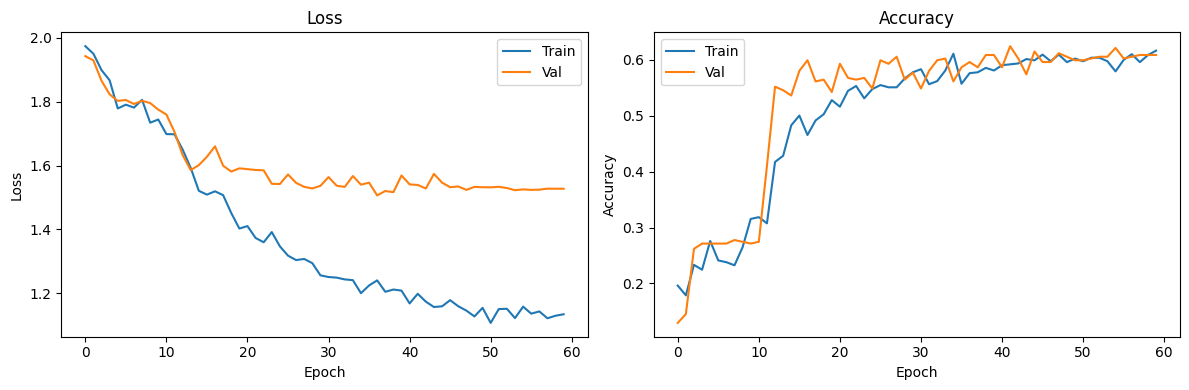

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_vit_location.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, locations, labels in test_loader:
        outputs = model(images.to(device), locations.to(device))
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

       crease       0.07      0.20      0.11        10
 crescent_gap       0.57      0.69      0.63        45
    inclusion       0.62      0.19      0.29        42
     oil_spot       0.50      0.24      0.33        41
punching_hole       0.64      0.98      0.77        43
   rolled_pit       0.20      0.33      0.25         6
    silk_spot       0.81      0.79      0.80       130

     accuracy                           0.62       317
    macro avg       0.49      0.49      0.45       317
 weighted avg       0.65      0.62      0.61       317



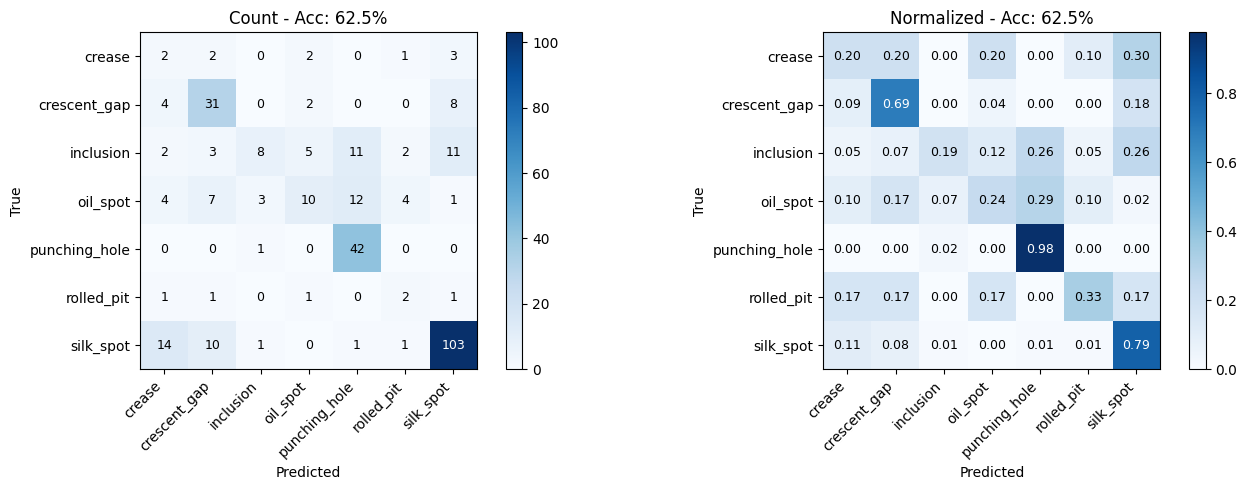

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ax, data, title in [(ax1, cm, 'Count'), (ax2, cm_norm, 'Normalized')]:
  im = ax.imshow(data, cmap='Blues')
  ax.set_xticks(range(num_classes))
  ax.set_yticks(range(num_classes))
  ax.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
  ax.set_yticklabels(label_encoder.classes_)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  ax.set_title(f'{title} - Acc: {(all_preds == all_labels).mean():.1%}')

  for i in range(num_classes):
    for j in range(num_classes):
      val = f'{data[i, j]:.0f}' if title == 'Count' else f'{data[i, j]:.2f}'
      color = 'white' if data[i, j] > data.max()/2 else 'black'
      ax.text(j, i, val, ha='center', va='center', color=color, fontsize=9)

  plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'defect_vit_location.pth')

with open('label_encoder.pkl', 'wb') as f:
  pickle.dump(label_encoder, f)

config = {
    'img_size': IMG_SIZE,
    'patch_size': PATCH_SIZE,
    'in_channels': IN_CHANNELS,
    'num_classes': num_classes,
    'embed_dim': EMBED_DIM,
    'num_heads': NUM_HEADS,
    'num_layers': NUM_LAYERS,
    'mlp_dim': MLP_DIM,
    'dropout': DROPOUT,
    'loc_dim': LOC_DIM
}
with open('model_config.pkl', 'wb') as f:
  pickle.dump(config, f)

In [ ]:
def predict(image_path, xml_path):
  img = preprocess_image(image_path)
  if img is None:
    return None

  _, loc = load_annotation(xml_path)
  if loc is None:
    loc = [0.5, 0.5, 0.5, 0.5]  # default center

  img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(
      0).unsqueeze(0).to(device)
  loc_tensor = torch.tensor(loc, dtype=torch.float32).unsqueeze(0).to(device)

  model.eval()
  with torch.no_grad():
    outputs = model(img_tensor, loc_tensor)
    probs = F.softmax(outputs, dim=1)
    pred_idx = outputs.argmax(1).item()
    confidence = probs[0, pred_idx].item()

  return {
      'class': label_encoder.classes_[pred_idx],
      'confidence': confidence,
      'location': loc
  }